<a href="https://colab.research.google.com/github/kimhwijin/HandsOnMachineLearing/blob/main/Classifier_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])


In [43]:
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(70000, 784) (70000,)


label :  5


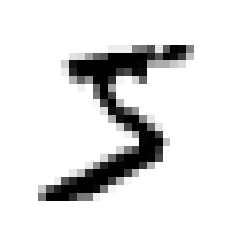

In [44]:
#데이터 확인
import matplotlib.pyplot as plt
import matplotlib as mpl

some_digit = X[0]
some_label = y[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show
print("label : ", some_label)

In [45]:
#레이블 타입 변환
y = y.astype(np.uint8)

In [46]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [47]:
from sklearn.linear_model import SGDClassifier

#이진분류기 y = 5 인경우만
y_train_5 = y_train == 5
y_test_5 = y_test == 5
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [48]:
print(sgd_clf.predict([some_digit]))

[ True]


In [49]:
#정확도 측정 구현
#k개 fold 교차검증
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

from sklearn.model_selection import cross_val_score
print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy'))

0.9669
0.91625
0.96785
[0.95035 0.96035 0.9604 ]


In [50]:
#5가 아닐확률 : 90%
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [51]:
#오차 행렬을 이용한 성능 평가
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train_5, y_train_pred))

(60000, 784)
[[53892   687]
 [ 1891  3530]]


In [55]:
from sklearn.metrics import precision_score, recall_score
#정밀도 평가
print(precision_score(y_train_5, y_train_pred)) # == 3530 / 3530 + 687
#민감도 평가
print(recall_score(y_train_5, y_train_pred)) # == 3530 / 3530 + 1891

0.8370879772350012
0.6511713705958311


In [56]:
#F1 점수
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


In [58]:
#결정 함수, 결정 임계값 측정
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

#임계값 상승
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)
#임계값을 높이면 재현율이 줄어든다.

[2164.22030239]
[ True]
[False]


In [59]:
#모든 훈련 세트 샘플 점수 구하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

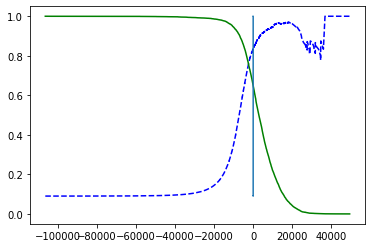

In [63]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

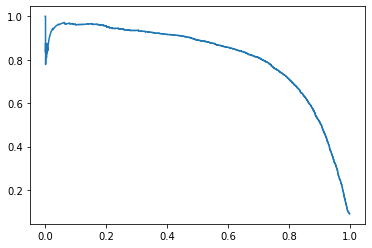

In [64]:
#재현율에 대한 정밀도
plt.plot(recalls[:-1], precisions[:-1], "-")
plt.show()

In [67]:
#정밀도 90%를 달성하는 분류기
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))
#낮은 재현율에서의 높은 정밀도는 의미없다!

0.9000345901072293
0.4799852425751706


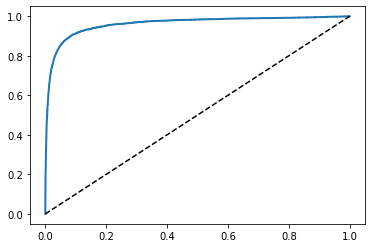

In [69]:
#TPR 에 대한 FPR 의 곡선그래프
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--")

plot_roc_curve(fpr, tpr)
plt.show()